In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [16]:
from google.colab import files
import shutil

# Criando pasta e realizando upload
os.makedirs("img", exist_ok=True)
uploaded = files.upload()

# Movendo arquivos para a pasta correta
for filename in uploaded.keys():
    shutil.move(filename, os.path.join("img", filename))

Saving cachoro2.jpg to cachoro2.jpg
Saving cachorro1.jpg to cachorro1.jpg
Saving cachorro3.jpg to cachorro3.jpg
Saving gato1.jpg to gato1.jpg
Saving gato2.jpg to gato2.jpg
Saving gato3.jpg to gato3.jpg


Erro: Não foi possível carregar a imagem em img/cachorro2.jpg


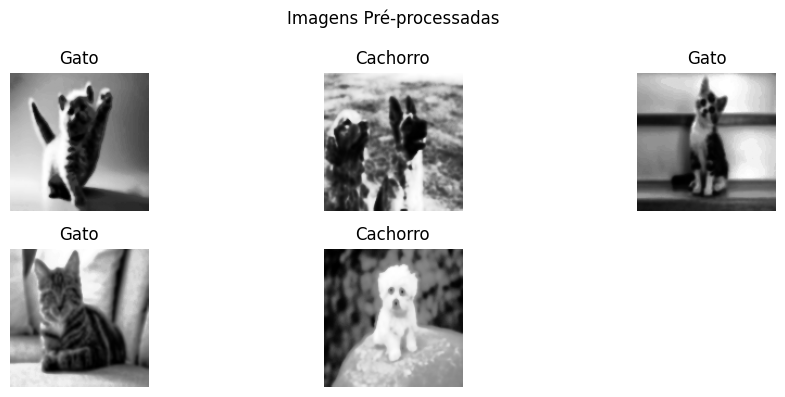

In [17]:
# Função para aplicar redimensionamento, filtro Gaussiano e equalização de histograma
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:  # Adicione esta verificação
        print(f"Erro: Não foi possível carregar a imagem em {image_path}")
        return None  # Retorna None ou lida com o erro conforme necessário

    img_resized = cv2.resize(img, (128, 128))
    img_blurred = cv2.GaussianBlur(img_resized, (5, 5), 0)
    gray = cv2.cvtColor(img_blurred, cv2.COLOR_BGR2GRAY)
    equalized = cv2.equalizeHist(gray)
    return equalized

# Pré-processamento das imagens
images = []
labels = []

for i in range(1, 4):
    # Processa imagens de "gato"
    processed_gato_img = preprocess_image(f"img/gato{i}.jpg")
    if processed_gato_img is not None:
        images.append(processed_gato_img)
        labels.append("Gato")

    # Processa imagens de "cachorro"
    processed_cachorro_img = preprocess_image(f"img/cachorro{i}.jpg")
    if processed_cachorro_img is not None:
        images.append(processed_cachorro_img)
        labels.append("Cachorro")

# Exibição das imagens processadas
plt.figure(figsize=(10, 4))
for i in range(len(images)):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(labels[i])
    plt.axis('off')
plt.suptitle("Imagens Pré-processadas")
plt.tight_layout()
plt.show()

In [18]:
# Carregando base CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Selecionando apenas as classes 3 (gato) e 5 (cachorro)
relevant_classes = [3, 5]
train_mask = np.isin(y_train, relevant_classes).flatten()
test_mask = np.isin(y_test, relevant_classes).flatten()

x = np.concatenate((x_train[train_mask], x_test[test_mask]), axis=0)
y = np.concatenate((y_train[train_mask], y_test[test_mask]), axis=0)

# Ajustando rótulos para binário
y = np.where(y == 3, 0, 1)  # 0 = Gato, 1 = Cachorro

# Normalização
x = x.astype('float32') / 255.0

# Separando 80% treino e 20% teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [19]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binária
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
history = model.fit(x_train, y_train, epochs=10,
                    validation_data=(x_test, y_test))

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.5637 - loss: 0.6733 - val_accuracy: 0.6687 - val_loss: 0.6134
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.6797 - loss: 0.5984 - val_accuracy: 0.7104 - val_loss: 0.5543
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.7123 - loss: 0.5560 - val_accuracy: 0.7208 - val_loss: 0.5488
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.7361 - loss: 0.5142 - val_accuracy: 0.7258 - val_loss: 0.5313
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.7626 - loss: 0.4875 - val_accuracy: 0.7337 - val_loss: 0.5339
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.7879 - loss: 0.4509 - val_accuracy: 0.7254 - val_loss: 0.5328
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.8048 - loss: 0.4209 - val_accuracy: 0.7333 - val_loss: 0.5342
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - accuracy: 0.8344 - loss: 0.3644 - 

In [22]:
# Predição e avaliação
y_pred = (model.predict(x_test) > 0.5).astype("int32")

# Métricas detalhadas
print("\nRelatório de Classificação:\n")
print(classification_report(y_test, y_pred, target_names=["Gato", "Cachorro"]))

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

Relatório de Classificação:

              precision    recall  f1-score   support

        Gato       0.74      0.78      0.76      1209
    Cachorro       0.77      0.72      0.75      1191

    accuracy                           0.75      2400
   macro avg       0.76      0.75      0.75      2400
weighted avg       0.76      0.75      0.75      2400

